In [1]:
!pip install -Uq segmentation-models-pytorch

In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 14.8 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize
import os
from torchvision import transforms


In [11]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2



class DepthDataset(Dataset):
    def __init__(self, paths, mode="train", size=(224, 224)):
        """
        paths: list các tuple (rgb_path, depth_path)
        mode: "train" hoặc "val"
        size: output size (w, h)
        """
        self.paths = paths
        self.mode = mode
        self.size = size

        self.resize = transforms.Resize(size)

        # Augmentations
        if mode == "train":
            self.tfms = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.GaussNoise(p=0.2),
                A.OneOf([
                    A.MotionBlur(p=0.3),
                    A.MedianBlur(blur_limit=3, p=0.3),
                    A.Blur(blur_limit=3, p=0.5),
                ], p=0.3),
                A.RGBShift(),
                A.RandomBrightnessContrast(),
                A.RandomResizedCrop(size[1], size[0]),   # (h,w)
                A.ColorJitter(),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3,
                                   rotate_limit=45, p=0.5),
                A.HueSaturationValue(p=0.3),
                # A.Resize(size[1], size[0]),  # đảm bảo đúng output size
                A.Normalize(mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225),
                            always_apply=True),
                ToTensorV2()
            ])
        else:  # val / test
            self.tfms = A.Compose([
                # A.Resize(size[1], size[0]),
                A.Normalize(mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225),
                            always_apply=True),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        rgb_path, depth_path = self.paths[index]

        # đọc ảnh
        rgb = cv2.imread(rgb_path)[:, :, ::-1]  # BGR -> RGB
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)

        rgb = Image.fromarray(rgb)
        depth = Image.fromarray(depth)

        # Resize
        rgb = self.resize(rgb)
        depth = self.resize(depth)

        rgb = np.array(rgb)
        depth = np.array(depth)


        # print(f"rgb: {rgb.shape}, depth: {depth.shape}")

        # augmentation đồng thời cho cả rgb và depth
        augs = self.tfms(image=rgb, mask=depth)
        rgb_tensor = augs['image']                      # (3,H,W)
        depth_tensor = augs['mask'] / 255.0             # chuẩn hóa về [0,1]
        depth_tensor = depth_tensor.unsqueeze(0)        # (1,H,W)

        return rgb_tensor, depth_tensor

In [12]:
def get_image_label_pairs(directory, img_ext=".png", label_ext=".png"):
    img_root = os.path.join(directory, "images")
    lbl_root = os.path.join(directory, "labels")

    pairs = []
    if not os.path.exists(img_root) or not os.path.exists(lbl_root):
        return pairs  # Không có thư mục thì trả rỗng

    for scene_name in sorted(os.listdir(img_root)):
        img_dir = os.path.join(img_root, scene_name)
        lbl_dir = os.path.join(lbl_root, scene_name)

        if not os.path.isdir(img_dir) or not os.path.isdir(lbl_dir):
            continue

        # Lọc file ảnh và depth
        img_files = set(f for f in os.listdir(img_dir) if f.endswith(img_ext))
        lbl_files = set(f for f in os.listdir(lbl_dir) if f.endswith(label_ext))

        # Lấy giao nhau để chắc chắn có cả RGB và depth
        common_files = sorted(img_files & lbl_files)

        for f in common_files:
            rgb_path = os.path.join(img_dir, f)
            depth_path = os.path.join(lbl_dir, f)
            if os.path.isfile(rgb_path) and os.path.isfile(depth_path):
                pairs.append((rgb_path, depth_path))

    return pairs

In [13]:
import os

In [14]:
# train_paths = get_image_label_pairs(os.path.join(data_root, "train"))
val_paths   = get_image_label_pairs(os.path.join("/home/tamcn/Desktop/test_algorithm/deep_learning/hyp_dataset/hypdataset_v1", "val"))
val_set   = DepthDataset(val_paths, mode="val", size=(224,224))

/tmp/ipykernel_38235/2742481012.py:49: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=(0.485, 0.456, 0.406),


In [15]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

/tmp/ipykernel_38235/2525276264.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img*std+mean


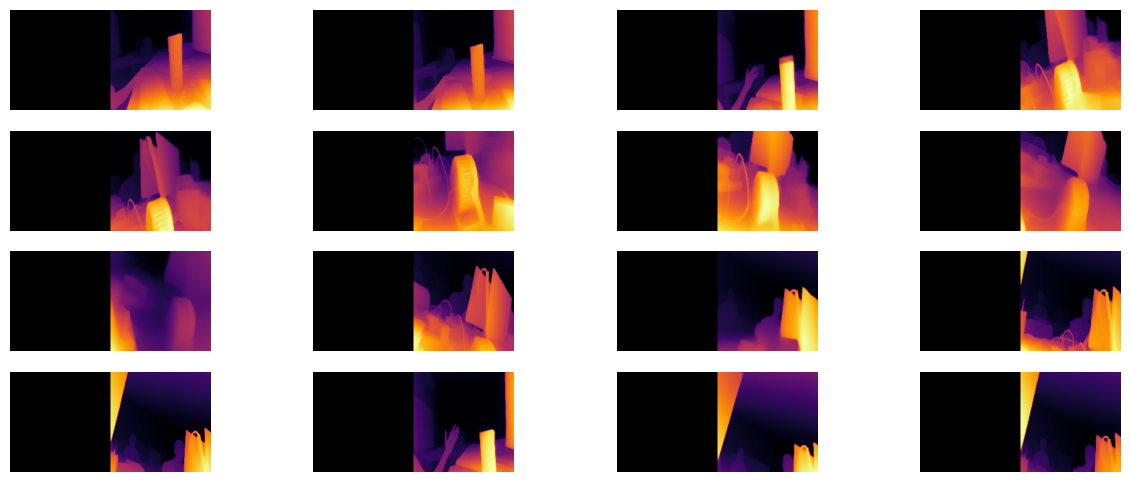

In [19]:
randoms = [val_set[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)

    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    
    img = img*std+mean

    img = np.transpose(img, (1,2,0))

    img, mask = img, mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")


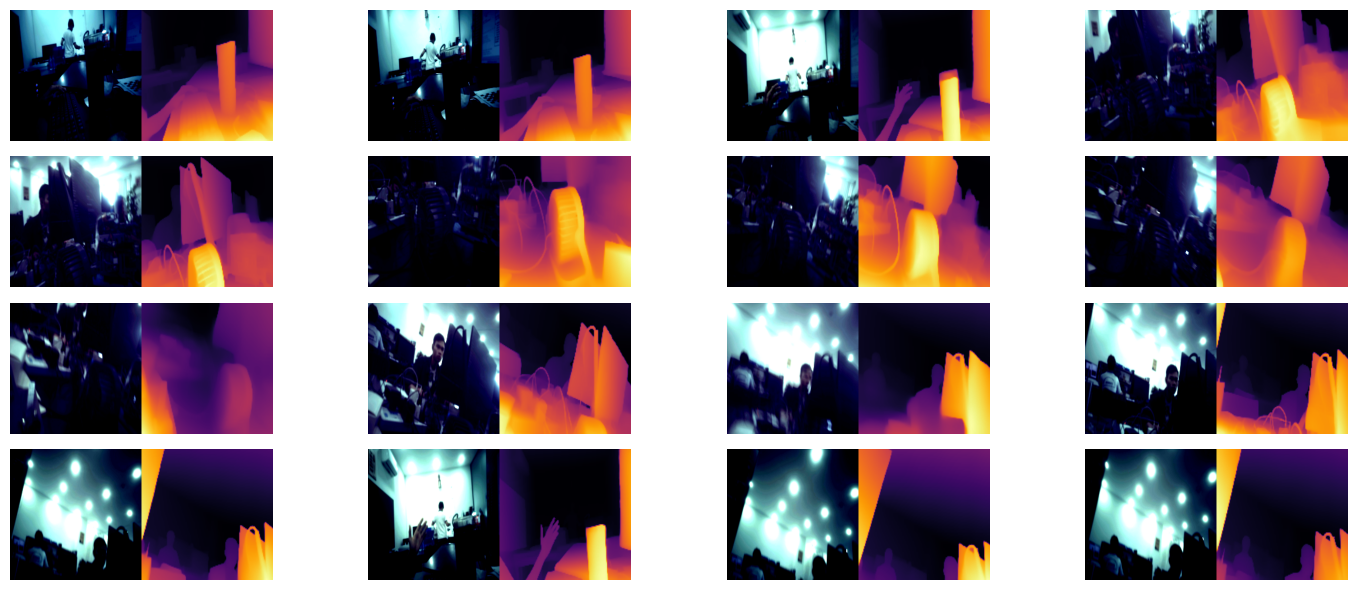

In [25]:
randoms = [val_set[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))

mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

for i, (img, depth) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)

    # to numpy
    if isinstance(img, torch.Tensor):   img = img.cpu().numpy()
    if isinstance(depth, torch.Tensor): depth = depth.cpu().numpy()

    # denorm RGB (C,H,W) -> (H,W,C)
    # img = (img * std + mean).clip(0, 1)
    img = (img).clip(0, 1)
    img = np.transpose(img, (1, 2, 0))      # HWC
    img_u8 = (img * 255).astype(np.uint8)   # -> uint8 0..255

    # depth (1,H,W) or (H,W)
    depth = np.squeeze(depth)

    # nếu depth đã ở [0,1] (đúng theo dataset của bạn):
    depth_01 = np.clip(depth, 0, 1)

    # if depth.max() <= 1.0 + 1e-6:
    #     depth_01 = np.clip(depth, 0, 1)
    # else:
    #     # fallback khi depth không ở [0,1]
    #     dmin, dmax = depth.min(), depth.max()
    #     depth_01 = (depth - dmin) / (dmax - dmin + 1e-8)

    depth_u8 = (depth_01 * 255).astype(np.uint8)
    depth_bgr = cv2.applyColorMap(depth_u8, cv2.COLORMAP_INFERNO)
    depth_rgb = cv2.cvtColor(depth_bgr, cv2.COLOR_BGR2RGB)  # matplotlib expects RGB

    # cùng dtype & range trước khi hstack
    image_viz = np.hstack([img_u8, depth_rgb])

    ax.imshow(image_viz)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [17]:
import random

/tmp/ipykernel_38235/2742481012.py:49: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=(0.485, 0.456, 0.406),
/tmp/ipykernel_38235/3617739919.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img*std+mean


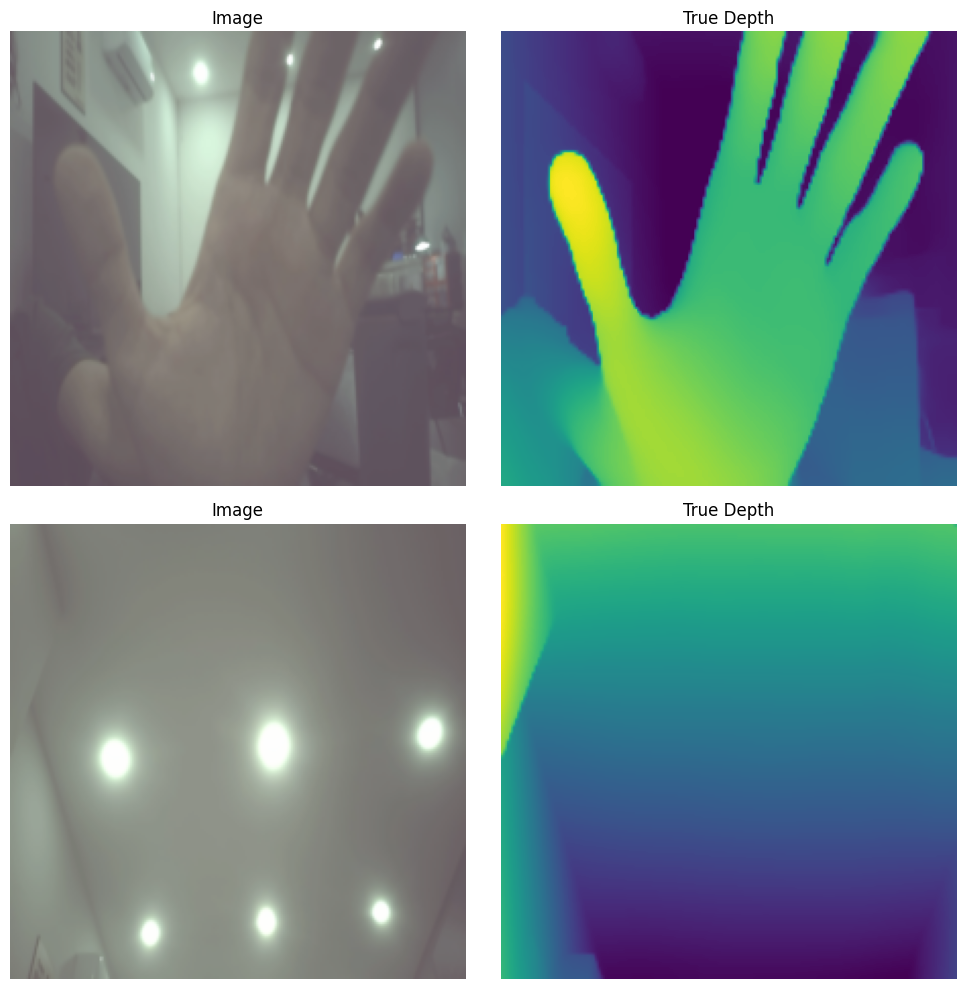

In [23]:
num_images = 2

fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

val_paths   = get_image_label_pairs(os.path.join("/home/tamcn/Desktop/test_algorithm/deep_learning/hyp_dataset/hypdataset_v1", "val"))
train_set   = DepthDataset(val_paths, mode="val", size=(224,224))

for i in range(num_images):
    idx = random.randint(0, len(train_set) - 1)  # chọn index ngẫu nhiên
    # print(f"i index: {i}")
    img, depth = train_set[idx]
    depth = depth.numpy().squeeze()*255
    # depth = cv2.applyColorMap(depth.astype(np.uint8), cv2.COLORMAP_INFERNO)
    # img, depth = sample['image'].numpy(), sample['depth'].numpy()

    # print(img)

    # print(f"img: {img.shape}")
    # print(f"depth: {depth.shape}")

    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img = img*std+mean

    # print(np.transpose(img, (1,2,0)))
    axes[i, 0].imshow(np.transpose(img, (1,2,0)))
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    im1 = axes[i, 1].imshow(depth, cmap='viridis', vmin=0)
    axes[i, 1].set_title('True Depth')
    axes[i, 1].axis('off')
    # fig.colorbar(im1, ax=axes[i, 1])
    

plt.tight_layout()

In [26]:
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='resnext50_32x4d',
            in_channels=3,
            classes=1
        )
        
    def trainable_encoder(self,trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable
        
    def forward(self,x):
        return self.model(x)
    
    def _num_params(self,):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])


In [27]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()


In [30]:
from torch.utils.data import Dataset, DataLoader

In [32]:
val_paths   = get_image_label_pairs(os.path.join("/home/tamcn/Desktop/test_algorithm/deep_learning/hyp_dataset/hypdataset_v1", "val"))
val_set   = DepthDataset(val_paths, mode="val", size=(224,224))
train_dl = DataLoader(val_set, batch_size=1,
                            shuffle=False, num_workers=4,
                            pin_memory=True)

/tmp/ipykernel_38235/2742481012.py:49: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=(0.485, 0.456, 0.406),


In [33]:
epochs = 5
freeze_epochs = 2
lr = 1e-3

device = 'cpu'

metrics = MetricCollection([
    SSIM(data_range=(0,1)),
    MSE()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']]=None

model = UNet().to(device)
model.trainable_encoder(trainable=False)

loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))

scaler = GradScaler()


/home/tamcn/miniconda3/envs/test/lib/python3.9/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading resnext50_32x4d `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)
/tmp/ipykernel_38235/863940263.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/tamcn/miniconda3/envs/test/lib/python3.9/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
best_ssim = -1e9
best_epoch = -1

print('training decoder only')

for epoch in tqdm(range(epochs)):
    
    model.train()
    
    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')
    
    running_loss = 0.
    train_prog = tqdm(train_dl,total=len(train_dl))
    
    for img, mask in train_prog:
        
        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item()

            train_prog.set_description(f'loss: {loss.item():.3f}')
            train_metrics(preds,mask)
        
        del img, mask, preds, loss

    m = train_metrics.compute()
    _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch,['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl),_ssim,_mse)
    train_metrics.reset()
    model.eval()
    
    with torch.no_grad():
        
        running_loss = 0.
        
        val_prog = tqdm(val_dl,total=len(val_dl))
        for img, mask in val_prog:

            with autocast():
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds,mask)
                running_loss += loss.item()
                val_prog.set_description(f'loss: {loss.item():.3f}')
                
                val_metrics(preds, mask)
                
            del img, mask, preds, loss
            
        m = val_metrics.compute()
        _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch,['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl),_ssim,_mse)
        val_metrics.reset()
    
    if _ssim > best_ssim:
        best_ssim = _ssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd,'nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')
        
    print(f"\n\n{logs.tail(1)}\n\n")
    
    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )
        
    gc.collect()
    torch.cuda.empty_cache()

Predictions

In [35]:
# best_epoch

In [ ]:
best_sd = torch.load('/kaggle/working/nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')
model.load_state_dict(best_sd)

In [ ]:
all_imgs, all_preds, all_targets = [], [], []
with torch.no_grad():
    with autocast():
        for img, mask in tqdm(test_dl,total=len(test_dl)):
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            all_imgs.append(img)
            all_preds.append(preds)
            all_targets.append(mask)

test_metrics = metrics.clone()
test_metrics(
    torch.vstack(all_preds),
    torch.vstack(all_targets)
)
m = test_metrics.compute()
title = f"SSIM: {m['StructuralSimilarityIndexMeasure'].cpu().item():.3f} MSE: {m['MeanSquaredError'].cpu().item():.3f}"
plot_vals(
    torch.vstack(all_imgs).cpu(),
    torch.vstack(all_preds).cpu(),
    torch.vstack(all_targets).cpu(),
    n=16,
    figsize=(10,15),
    title=title
)
